# Práctica 11: Análisis de Componentes Principales

Machine Learning

Universidad Iberoamericana Ciudad de México

Otoño 2023

Creado por: Luis Norberto Zúñiga Morales, inspirado en el libro *Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow*.

## Librerías

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import numpy as np
from sklearn.datasets import make_blobs

## Creación y visualización de los datos

Para este primer bloque de la práctica vamos a utilizar un conjunto de datos artificial que se pueda visualizar:

In [ ]:
X, y = make_blobs(n_samples=500, centers=3, n_features=3, random_state=0)

/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


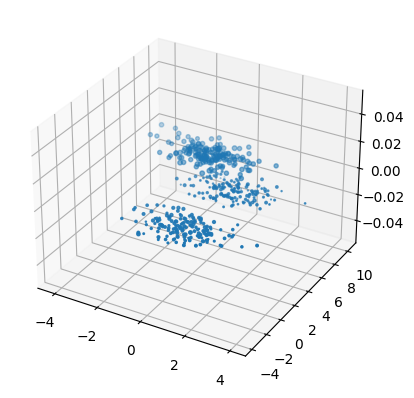

In [ ]:
fig1 = plt.figure()
ax = fig1.add_subplot(projection='3d')
plt.scatter(X[:,0], X[:,1], X[:,2])
plt.show()

## Componentes principales a mano

Scikit-learn utiliza la descomposición SVD (*Singular Value Decomposition*) para la implementación de PCA. En resumen, la matriz $X$ de datos se puede descomponer como el producto de tres matrices:

$$X = UΣV^T$$

donde $V$ contiene los vectores unitarios que definen todas las componentes principales que estamos buscando:

$$ V = \begin{pmatrix}
| & | & & |\\
c_1 & c_2 & \cdots &c_n\\
| & | & & |
\end{pmatrix}$$

El siguiente código utiliza la función de Numpy `svd()` para obtener las componentes principales del conjunto de entrenamiento, para después extraer los primera $n$ vectores unitarios que definen las primeras $n$ componentes principales:

**Pregunta**: ¿Qué es la descomposición SVD? ¿Cómo se aplica en PCA?

Respuesta:

In [ ]:
n_comp = 2
X_centered = X - X.mean(axis=0)
U, s, V = np.linalg.svd(X_centered)
print(f'Las componentes principales son: \n {V.T}')

for i in range(n_comp):
  print(f'La {i}-ésima componente es el vector {V.T[:,i]}')

Las componentes principales son: 
 [[ 0.19665206 -0.20628602 -0.95852702]
 [-0.7627071  -0.64651155 -0.0173408 ]
 [-0.61612162  0.73448546 -0.28447364]]
La 0-ésima componente es el vector [ 0.19665206 -0.7627071  -0.61612162]
La 1-ésima componente es el vector [-0.20628602 -0.64651155  0.73448546]


Ya que tenemos identificadas las componentes principales, podemos reducir la dimensionalidad del conjunto de datos a $d$ projectandolo al hiperplano definido por las primeras $d$ componenetes principales mediante la siguiente operación:

$$X_{d} = XW_d$$

donde $W_d$ es la matriz que contiene las primeras $d$ columnas de $V$.

Para implementarlo en Python, se puede hacer lo siguiente:

In [ ]:
W2 = V.T[:,:2] # elegimos las primeras 2 columnas de V
X2D = X_centered.dot(W2)

Vamos a graficar los nuevos datos con un diagrama de dispersión:

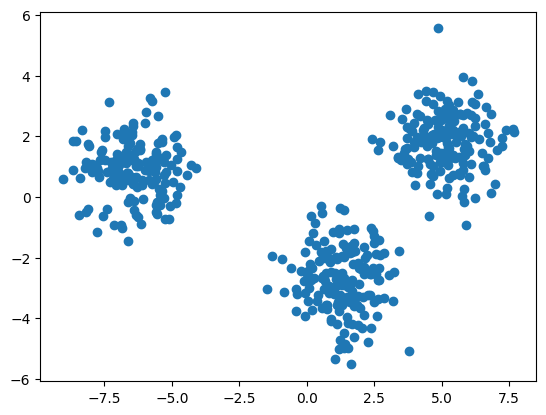

In [ ]:
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)
ax.scatter(X2D[:,0], X2D[:,1])
plt.show()

## PCA con Scikit-learn

El siguiente código aplica PCA para reducir la dimensionalidad del conjunto de datos $X$ a dos dimensiones. Noten que se encarga de centrar los datos en automático:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_X2D = pca.fit_transform(X)

**Pregunta:** Revisar la documentación de PCA en scikit-learn y escribir sobre los parámetros del modelo.

Respuesta:

Después de ajustar el transformador de PCA con los datos, el atributo `components_` contiene la trasnpuesta de $W_d$.

In [ ]:
pca.components_

array([[-0.19665206,  0.7627071 ,  0.61612162],
       [-0.20628602, -0.64651155,  0.73448546]])

## Razón de explicación de varianza

Otra parte informativa del método se encuentra en la variable `explained_variance_ratio`. Esta razón indica la proporción de varianza del dataset que yace en cada componete principal. Vamos a dar un vistazo a las razones de explicación de varianza de las primeras dos componentes:

In [ ]:
pca.explained_variance_ratio_

array([0.80822702, 0.16057772])

Este resultado indica que el 84.2% de la varianza de los datos yace en la primera componente, mientras que el 14.6% yace en la segunda. Esto deja menor del 1.2% en la tercera componente principal.

## Elección del número correcto de dimensiones

En lugar de seleccionar arbitrariamente el número de dimensiones a las cuales reducir los datos, es mejor (y más simple) elegir el número de dimensiones de tal manera que la suma de la porción de la varianza que conservan sea relativamente alta. Un valor estándar es elegir tal número de tal manera que se conserve al menos el 95% de la varianza.

Para implementar esta idea en scikit-learn se puede hacer lo siguiente:

In [ ]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

2

O bien, hacerlo directo de la siguiente manera:

In [ ]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

Vamos a graficarlo:

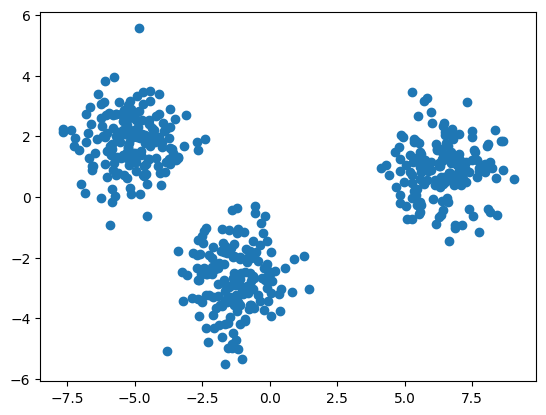

In [ ]:
fig3 = plt.figure()
ax = fig3.add_subplot(1,1,1)
ax.scatter(X_pca[:,0], X_pca[:,1])
plt.show()

## PCA Aleatorizado

Uno de los parámetros de la implementación de PCA en scikit-learn es `svd_solver`, el cual indica que método usar para determinar la decomposición SVD de nuestros datos $X$. Uno de los parámetros es `randomnized`, el cual usa una implementación estocástica del algoritmo *Randomnized PCA* que se enfoca en encontrar una aproximación rápida de los primeros $d$ componentes principales.

En contraste, este algoritmo tiene complejidad $O(m \times d^2) + O(d^3)$, en lugar de $O(m \times n^2) + O(n^3)$ del algoritmo completo de SVD. Es mucho más rápido cuando $d < n$.

Por default utiliza `auto`:



> *The solver is selected by a default policy based on X.shape and n_components: if the input data is larger than 500x500 and the number of components to extract is lower than 80% of the smallest dimension of the data, then the more efficient ‘randomized’ method is enabled. Otherwise the exact full SVD is computed and optionally truncated afterwards.*



Vamos a ver si la proyección cambia si usamos `full` en los datos generados por `make_blob`:

In [ ]:
full_pca = PCA(n_components=2, svd_solver = 'full')
X_pca_full = full_pca.fit_transform(X)

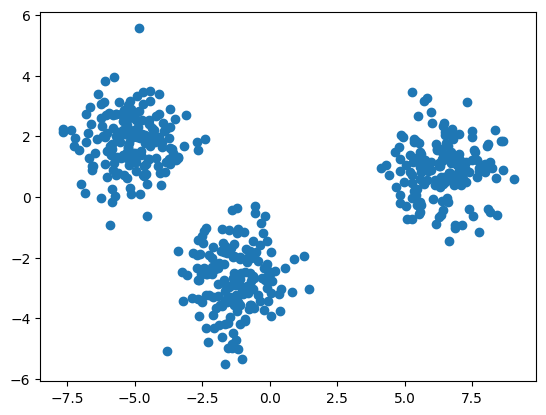

In [ ]:
fig4 = plt.figure()
ax = fig4.add_subplot(1,1,1)
ax.scatter(X_pca_full[:,0], X_pca_full[:,1])
plt.show()

## PCA como compresión de información

Después de aplicar PCA, un conjunto de datos ocupa menos espacio. Por ejemplo, vamos a aplicarlo en el dataset MNIST conservando el 95% de varianza.

In [ ]:
from tensorflow import keras

mnist = keras.datasets.mnist
(X_train,y_train), (X_test,y_test) = mnist.load_data()

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])

In [ ]:
X_train.shape

(60000, 784)

In [ ]:
pca = PCA(n_components = 0.95)
X_train_reduced = pca.fit_transform(X_train)

Veamos la dimensión de nuestro datos con menor dimensionalidad:

In [ ]:
X_train_reduced.shape

(60000, 154)

En total, con 154 dimensiones conservamos al menos 95% de la varianza, en contraste de las 784 dimensiones originales del conjunto de datos.

También es posible descomprimir el conjunto de datos reducido a las 784 dimensiones originales aplicando la transformación inversa de la proyección que aplica PCA.

$$X_{recuperada} = X_d W_d^T$$

Esto no regresa toda la información original, ya que perdimos 5% de la varianza, pero el resultado es cercano al original.

In [ ]:
X_recovered = pca.inverse_transform(X_train_reduced)

Vamos a graficar la diferencia entre los objetos originales y los descomprimidos con esta transformación inversa:

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 28, 28)

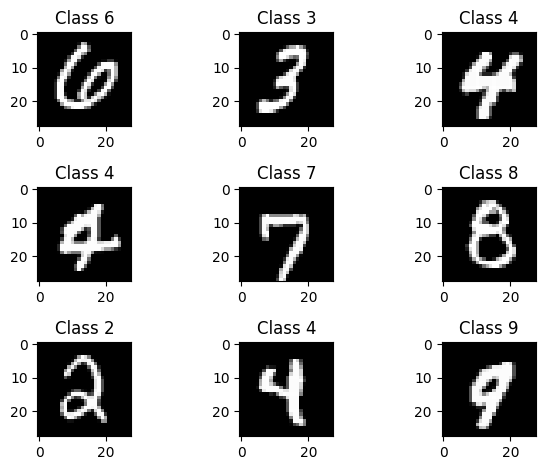

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

In [ ]:
X_recovered = X_recovered.reshape(X_recovered.shape[0], 28, 28)

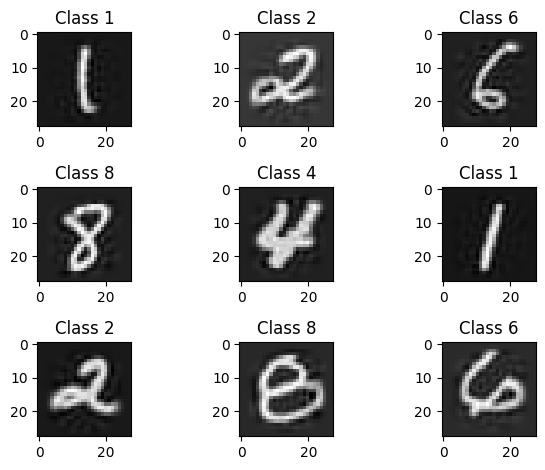

In [ ]:
for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_recovered))
    plt.imshow(X_recovered[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

## PCA incremental

Un problema que surge con las implementaciones anteriores de PCA es que requieren todos los datos para ejecutar el algoritmo, lo cual puede ser algo complejo si no caben en memoria. Similar a la idea de batch gradient descent, Incremental PCA permite partir el conjunto de entrenamiento en pequeños lotes y ejectuar el algoritmo, un lote a la vez. Lo anterior es muy útil cuando se manejan grandes conjuntos de datos o bien, se hace en tiempo real.

El siguiente código fragmenta el conjunto de datos MNIST en 100 lotes mediante la función `array_split()` de numpy, para después alimentar cada partición a la clase `IncrementalPCA` de [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html).

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

## Actividad

Elegir un conjunto de datos disponible en scikit-learn y comparar el rendimiento del modelo con y sin la aplicación de reducción de dimensionalidad.

La estructura general del proyecto se vería como:

1. Importar los datos.
2. Aplicar o no reducción de dimensionalidad.
3. Entrenar su modelo con los datos.
4. Obtener métricas de validación. Para clasificación reportar la medida F1; para regresión reportar la medida $R^2$.